In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import os
import wandb
from torchvision.transforms import Resize, ToTensor, Normalize, Pad, Compose, RandomRotation, RandomHorizontalFlip, RandomVerticalFlip
# Initialize WandB
wandb.init(project="Femoral Slice Classifier")


class SliceClassifierCNN(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.5):
        super(SliceClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout2d(p=dropout_prob)  # Add dropout
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout2d(p=dropout_prob)  # Add dropout
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout2d(p=dropout_prob)  # Add dropout
        self.fc1 = nn.Linear(128 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.dropout1(x)  # Apply dropout
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)
        x = self.dropout2(x)  # Apply dropout
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)
        x = self.dropout3(x)  # Apply dropout
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


    def train_model(self, dataloader, num_epochs, learning_rate):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f'Using device: {device}')
        self.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            correct_predictions = 0
            total_samples = 0

            # Wrap your dataloader with tqdm for the progress bar
            for inputs, labels in tqdm(dataloader, total=len(dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}', colour='red'):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                # Compute accuracy
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)

            accuracy = correct_predictions / total_samples

            wandb.log({
                "Loss": running_loss / len(dataloader),
                "Accuracy": accuracy,
                "Epoch": epoch,
            })

            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(dataloader)}, Accuracy: {accuracy}')

        print('Training complete!')


    def save_model(self, model_path):
        torch.save(self.state_dict(), model_path)
        print(f'Model saved to {model_path}')

    @classmethod
    def load_model(cls, model_path, num_classes):
        model = cls(num_classes)
        model.load_state_dict(torch.load(model_path))
        return model    


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pappol. Use `wandb login --relogin` to force relogin


In [10]:
class SliceClassifierResNet(nn.Module):
    def __init__(self, num_classes):
        super(SliceClassifierResNet, self).__init__()
        # Load a pretrained ResNet-18 model
        self.resnet = torchvision.models.resnet18(pretrained=True)
        
        # Change the first layer to accept 1 channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Freeze all layers except the final classifier layer
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.resnet.fc.requires_grad = True

        # Modify the final classifier layer to match the number of classes
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)


    def forward(self, x):
        return self.resnet(x)

    def train_model(self, dataloader, num_epochs, learning_rate):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f'Using device: {device}')
        self.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            correct_predictions = 0
            total_samples = 0

            # Wrap your dataloader with tqdm for the progress bar
            for inputs, labels in tqdm(dataloader, total=len(dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}', colour='red'):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                # Compute accuracy
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)

            accuracy = correct_predictions / total_samples

            wandb.log({
                "Loss": running_loss / len(dataloader),
                "Accuracy": accuracy,
                "Epoch": epoch,
            })

            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(dataloader)}, Accuracy: {accuracy}')

        print('Training complete!')

    def save_model(self, model_path):
        torch.save(self.state_dict(), model_path)
        print(f'Model saved to {model_path}')

    @classmethod
    def load_model(cls, model_path, num_classes):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = cls(num_classes)
        model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        return model

In [3]:
def calculate_mean_and_std(dataset):
    """
    Calculate the mean and standard deviation of a dataset.
    
    Parameters:
    - dataset (Dataset): a PyTorch Dataset object that returns images.

    Returns:
    - tuple: (mean, std) of the dataset.
    """
    loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=4)

    mean = 0.0
    std = 0.0
    total_images = 0

    for images, _ in loader:
        # Assuming images are stacked in shape (B, C, H, W)
        # where B is the batch size, C is the number of channels,
        # H is the height and W is the width of the image.

        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images

    return mean, std

In [4]:
class PadToSquare:
    def __init__(self, fill):
        self.fill = fill

    def __call__(self, img):
        # Convert tensor to PIL Image if it's a tensor
        if isinstance(img, torch.Tensor):
            img = to_pil_image(img)
        
        # Calculate padding
        width, height = img.size
        max_wh = max(width, height)
        pad_width = (max_wh - width) // 2
        pad_height = (max_wh - height) // 2
        padding = (pad_width, pad_height, pad_width if width % 2 == 0 else pad_width + 1, pad_height if height % 2 == 0 else pad_height + 1)
        
        # Pad and return image
        img = Pad(padding, fill=self.fill)(img)
        return img



In [5]:
from SliceDatasetBuilder import CustomHipDataset
import datetime

json_path = "label.json"  # Update this to the path where your image dataset is located
num_classes = 2
batch_size = 16
num_epochs = 10
learning_rate = 0.001
date = datetime.datetime.now().strftime("%H%M%S")

model_path = f"modelResNet_{date}.pth"

mean = 0.2143
std = 0.1621


In [6]:
transform = Compose([
    #RandomRotation(degrees=(-10, 10)),  # Randomly rotate the image within the range of -10 to 10 degrees
    #RandomHorizontalFlip(0.5),  # Randomly flip the image horizontally
    #RandomVerticalFlip(0.5),  # Randomly flip the image vertically
    PadToSquare(fill=mean),  # Pad the image to make it square
    Resize((512, 512)),  # Resize the image to the desired size
    ToTensor(),
    Normalize(mean, std)  # Normalize with the dataset's mean and std
])

dataset = CustomHipDataset(json_path,['axial'], transform=transform)
dataset.balance_dataset()

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Plot some info about the dataset
print(f'Total number of samples: {len(dataset)}')
image_paths, labels = dataset.get_all_dataset()
print(f'Number of positive samples: {sum(labels)}')
print(f'Number of negative samples: {len(labels) - sum(labels)}')

imbalanceTrue = round(sum(labels) / len(labels), 2)
print(f'Imbalance ratio: {imbalanceTrue}')

Loading data/dataset/normalHip/JOR01/axial...
Positive interval of JOR01: [330, 400] for SX
Positive interval of JOR01: [280, 370] for DX
Loading data/dataset/normalHip/JOR02/axial...
Positive interval of JOR02: [250, 380] for SX
Positive interval of JOR02: [340, 445] for DX
Loading data/dataset/normalHip/JOR09/axial...
Positive interval of JOR09: [240, 300] for SX
Positive interval of JOR09: [230, 290] for DX
Loading data/dataset/dysplasticHip/TRAD09/axial...
Positive interval of TRAD09: [130, 190] for SX
Positive interval of TRAD09: [255, 320] for DX
Loading data/dataset/dysplasticHip/TRAD10/axial...
Positive interval of TRAD10: [355, 430] for SX
Positive interval of TRAD10: [230, 325] for DX
Loading data/dataset/retrovertedHip/Patient_01/axial...
Positive interval of Patient_01: [210, 270] for SX
Positive interval of Patient_01: [200, 260] for DX
Loading data/dataset/retrovertedHip/Patient_02/axial...
Positive interval of Patient_02: [230, 285] for SX
Positive interval of Patient_02

Balancing dataset: 100%|██████████| 9824/9824 [00:00<00:00, 3313884.71it/s]

Dataset balanced: 903 positive images and 903 negative images
Total number of samples: 1806
Number of positive samples: 903
Number of negative samples: 903
Imbalance ratio: 0.5


In [7]:
# Select model
TRAIN = True

if TRAIN:
    model = SliceClassifierResNet(num_classes)
    #model = SliceClassifierCNN(num_classes)
    # Train the model 
    model.train_model(dataloader, num_epochs, learning_rate)
    model.save_model(model_path)

/home/pappol/anaconda3/envs/medical/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pappol/anaconda3/envs/medical/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda


Epoch 1/10: 100%|██████████| 113/113 [00:33<00:00,  3.36it/s]


Epoch 1/10, Loss: 0.652016840149871, Accuracy: 0.6074197120708749


Epoch 2/10: 100%|██████████| 113/113 [00:36<00:00,  3.12it/s]


Epoch 2/10, Loss: 0.5502211739004186, Accuracy: 0.7286821705426356


Epoch 3/10: 100%|██████████| 113/113 [00:35<00:00,  3.14it/s]


Epoch 3/10, Loss: 0.4786845577501618, Accuracy: 0.778516057585825


Epoch 4/10: 100%|██████████| 113/113 [00:36<00:00,  3.13it/s]


Epoch 4/10, Loss: 0.4380621190092205, Accuracy: 0.8294573643410853


Epoch 5/10: 100%|██████████| 113/113 [00:32<00:00,  3.44it/s]


Epoch 5/10, Loss: 0.39858809838780257, Accuracy: 0.8482834994462901


Epoch 6/10: 100%|██████████| 113/113 [00:34<00:00,  3.32it/s]


Epoch 6/10, Loss: 0.3924768375875676, Accuracy: 0.8438538205980066


Epoch 7/10: 100%|██████████| 113/113 [00:34<00:00,  3.27it/s]


Epoch 7/10, Loss: 0.3418507768517047, Accuracy: 0.8997785160575859


Epoch 8/10: 100%|██████████| 113/113 [00:36<00:00,  3.06it/s]


Epoch 8/10, Loss: 0.33122634518463, Accuracy: 0.8942414174972314


Epoch 9/10: 100%|██████████| 113/113 [00:37<00:00,  3.05it/s]


Epoch 9/10, Loss: 0.31772574452699814, Accuracy: 0.9008859357696567


Epoch 10/10: 100%|██████████| 113/113 [00:34<00:00,  3.31it/s]

Epoch 10/10, Loss: 0.30724695878746233, Accuracy: 0.8947951273532669
Training complete!
Model saved to modelResNet_223329.pth


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

#TEST CLASSIFIER
loaded = SliceClassifierResNet.load_model('modelResNet_223329.pth', num_classes)
loaded.eval()

# Load images from a folder
folder_path = "data/dataset/retrovertedHip/Patient_06/axial"

image_array = []
for filename in os.listdir(folder_path):
        # Sample every 10 images
        if int(filename.split('_')[-2]) % 20 != 0:
                continue
        file_path = os.path.join(folder_path, filename)
        image = Image.open(file_path).convert("RGB").convert("L")
        if transform is not None:
                image = transform(image)
        image_array.append(image)

print(f'Number of images: {len(image_array)}')

Number of images: 100


In [12]:
# Make predictions using the loaded model
predictions = []
for image in image_array:
    image = image.unsqueeze(0)
    predictions.append(loaded(image))      

2: Normal


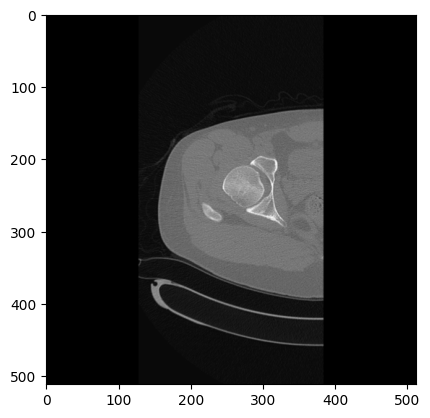

42: Normal


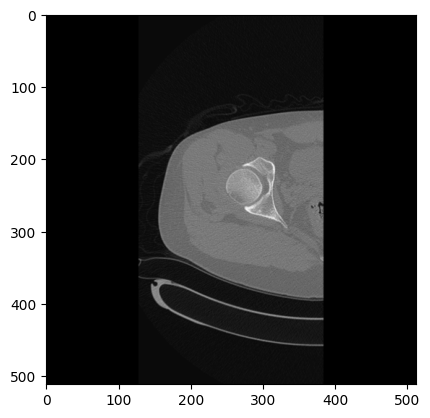

In [13]:
# Print the predictions
for index, value in enumerate(predictions):
    # Get the predicted class with the highest score
    pred_class = value.argmax(dim=1, keepdim=True)
    if pred_class.item() == 1:
        print(f'{index + 1}: Normal')
        plt.imshow(image_array[index].squeeze(), cmap='gray')
        plt.show() 